# Documentation for the creation and usage of the heatpump library (hplib)




In [2]:
import hplib as hpl
import hplib_database as db
import pandas as pd
import matplotlib.pyplot as plt

## Defintions

**Abbreviations**

| Abbreviation | Meaning |
| --- | --- |
| P_th | Thermal output power in W |
| P_el | Electical input Power in W |
| COP | Coefficient of performance |
| T_in | Input temperature in °C at primary side of the heat pump |
| T_out | Output temperature in °C at secondary side of the heat pump |
| P_th_ref | Thermal output power in W at T_in = -7 °C and T_out = 52 °C |
| P_el_ref | Elecrical output power in W at T_in = -7 °C and T_out = 52 °C |
| COP_ref | Coefficient of performance at T_in = -7 °C and T_out = 52 °C |
| p1,p2,p3 | Fit-Parameters for Fit-Function |


**Group IDs**

| Group ID | Type | Subtype |
| --- | --- | --- |
| 1 | Outdoor Air / Water | Inverter | 
| 2 | Brine / Water | Inverter | 
| 3 | Water / Water | Inverter | 
| 4 | Outdoor Air / Water | On-Off | 
| 5 | Brine / Water | On-Off | 
| 6 | Water / Water | On-Off | 
| 7 | Outdoor Air / Water | 2-Stages | 
| 8 | Brine / Water | 2-Stages |
| 9 | Water / Water | 2-Stages |

## Database Preparation
1. we downloaded all manufacturer data from https://keymark.eu/en/products/heatpumps/certified-products
2. then we unzipped the files and used the bash-skript to convert pdf into txt
3. afterwards we used this following functions to create and extent the heatpump keymark database

In [ ]:
# Import keymark data and save to csv database
db.ImportKeymarkData()
# -> this creates /output/database_keymark.csv)

In [ ]:
# Reduce to climate measurement series with average climate, delete redundant entries and save to csv sub-database
db.ReduceKeymarkData('database_keymark.csv','average')
# -> this creates /output/database_keymark_average.csv)

In [ ]:
# Normalize electrical and thermal power from the keymark database to values from setpoint T_in = -7 °C and T_out = 52 °C
db.NormalizeKeymarkData('database_keymark_average.csv')
# -> this creates /output/database_keymark_average_normalized.csv)

In [ ]:
# Identify subtypes like On-Off, Inverter and 2-stages Heatpump and assign group depending on its type and subtype
db.IdentifySubtypes('database_keymark_average_normalized.csv')
# -> this creates /output/database_keymark_average_normalized_subtypes.csv)

In [ ]:
#Calculate parameters p1-p3 for P_th, P_el and COP
db.CalculateFunctionParameters('database_keymark_average_normalized_subtypes.csv')
# -> this creates the final hplib_database.csv

In [ ]:
#Calculate generic heatpump models for each group
db.addGeneric()
# -> this overwrites the hplib_database.csv

In [ ]:
#Reduce to unique heat pump models
db.ReduceToUnique()
# -> this overwrites the hplib_database.csv

## Usage for simulation

In [ ]:
# Have a look into the hplib database
database = hpl.loadDatabase()
database

In [ ]:
# Define a specific heatpump model and get parameters
parameters = hpl.getParameters('i-SHWAK V4 06')
parameters

In [ ]:
# Alternatively, define a "Generic" heatpump model and get parameters
# For every Group ID there is a parameter set which represents an average heatpump of its group
# Please define the Type "Generic", the Group ID (1-9) and P_th_ref in W
parameters = hpl.getParameters('Generic',1,10000)
parameters

In [ ]:
# Simulate on time step
# Please define T_in_primary, T_in_secondary in °C and the parameters from the previous step 
# The T_in_secondary is supposed to be heated up by 5 K which then results in T_out
# For a time series create a loop with the function
P_th, P_el, COP = hpl.simulate(-7, 47, parameters)
print('P_th: '+str(int(P_th))+' W')
print('P_el: '+str(int(P_el))+' W')
print('COP: '+str(round(COP,3)))

**Very important:** With the Fit-Parameters p1-p3 for P_th, P_el and COP it is possible to calculate the results with the following methods:

1. P_th and P_el with Fit-Functions and `COP = P_th / P_el`
2. P_th and COP with Fit-Functions and `P_el = P_th / COP`
3. P_el and COP with Fut-Functions and `P_th = P_el * COP`

While the model by Schwarmberger et. al. uses the 1. method, our validation showed, that the 3. method results in better results. Therefore we decided to implement this in the `simulate` definition.

## Examples

**Schematic plotting** of P_th, P_el and COP for an generic air/water heat pump: subtype = **On-Off** 

<AxesSubplot:xlabel='T_in_primary'>

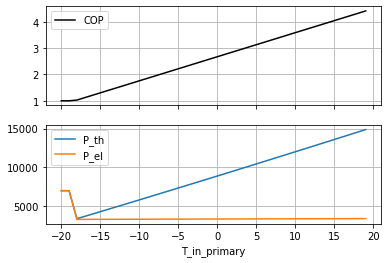

In [13]:
# Define Temperatures
T_in_primary = range(-20, 20) # air temperatur
T_in_secondary = 45 # e.g. temperature from hot water storage

# Load parameters of Generic Air/Water, On-Off
parameters = hpl.getParameters('LW 101')

# Simulate 
names = ['T_in_primary','P_th', 'P_el', 'COP', 'T_out', 'm_dot']
data = []

for t in T_in_primary:
    P_th, P_el, COP, T_out, m_dot = hpl.simulate(t, T_in_secondary, parameters)
    data.append([t, P_th, P_el, COP, T_out, m_dot])

results = pd.DataFrame(data, columns=names)

# Plot
fig, axes = plt.subplots(nrows=2, ncols=1, sharex=True)
results.plot(ax=axes[1],x='T_in_primary',y=['P_th','P_el'],grid=True)
results.plot(ax=axes[0],x='T_in_primary',y=['COP'],color='black', grid=True)

In [14]:
results

,T_in_primary,P_th,P_el,COP,T_out,m_dot
0,-20,6980.000000,6980.000000,1.000000,50,0.332381
1,-19,6980.000000,6980.000000,1.000000,50,0.332381
2,-18,3358.847411,3268.407690,1.027671,50,0.159945
3,-17,3661.039218,3271.167195,1.119184,50,0.174335
4,-16,3963.736088,3273.926700,1.210698,50,0.188749
5,-15,4266.938023,3276.686205,1.302211,50,0.203188
6,-14,4570.645021,3279.445710,1.393725,50,0.217650
7,-13,4874.857083,3282.205215,1.485238,50,0.232136
8,-12,5179.574209,3284.964719,1.576752,50,0.246646
9,-11,5484.796398,3287.724224,1.668265,50,0.261181
